<a href="https://colab.research.google.com/github/asmasw6/FCIT-project/blob/main/AI_Project_Fire_Detection_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50

import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
import hashlib

DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/fire_dataset'

/content/drive/.shortcut-targets-by-id/1-v0uyL-H1SwZQE65luo-8weqCC9BNRBS/fire_dataset


In [ ]:
train_data = '/content/drive/MyDrive/fire_dataset'
print(os.listdir(train_data))

['fire_images', 'non_fire_images']


In [ ]:
!cp -r . "/content/"

In [ ]:
fire_path = os.path.join(train_data, 'fire_images')
non_fire_path = os.path.join(train_data, 'non_fire_images')

In [ ]:
# List files
train_fire = [file for file in os.listdir(fire_path) if file.startswith('fire')]
train_not_fire = [file for file in os.listdir(non_fire_path) if file.startswith('non_fire')]

In [ ]:
print("length of no fire images:", len(train_not_fire))
print("length of fire images:", len(train_fire))

length of no fire images: 244
length of fire images: 765


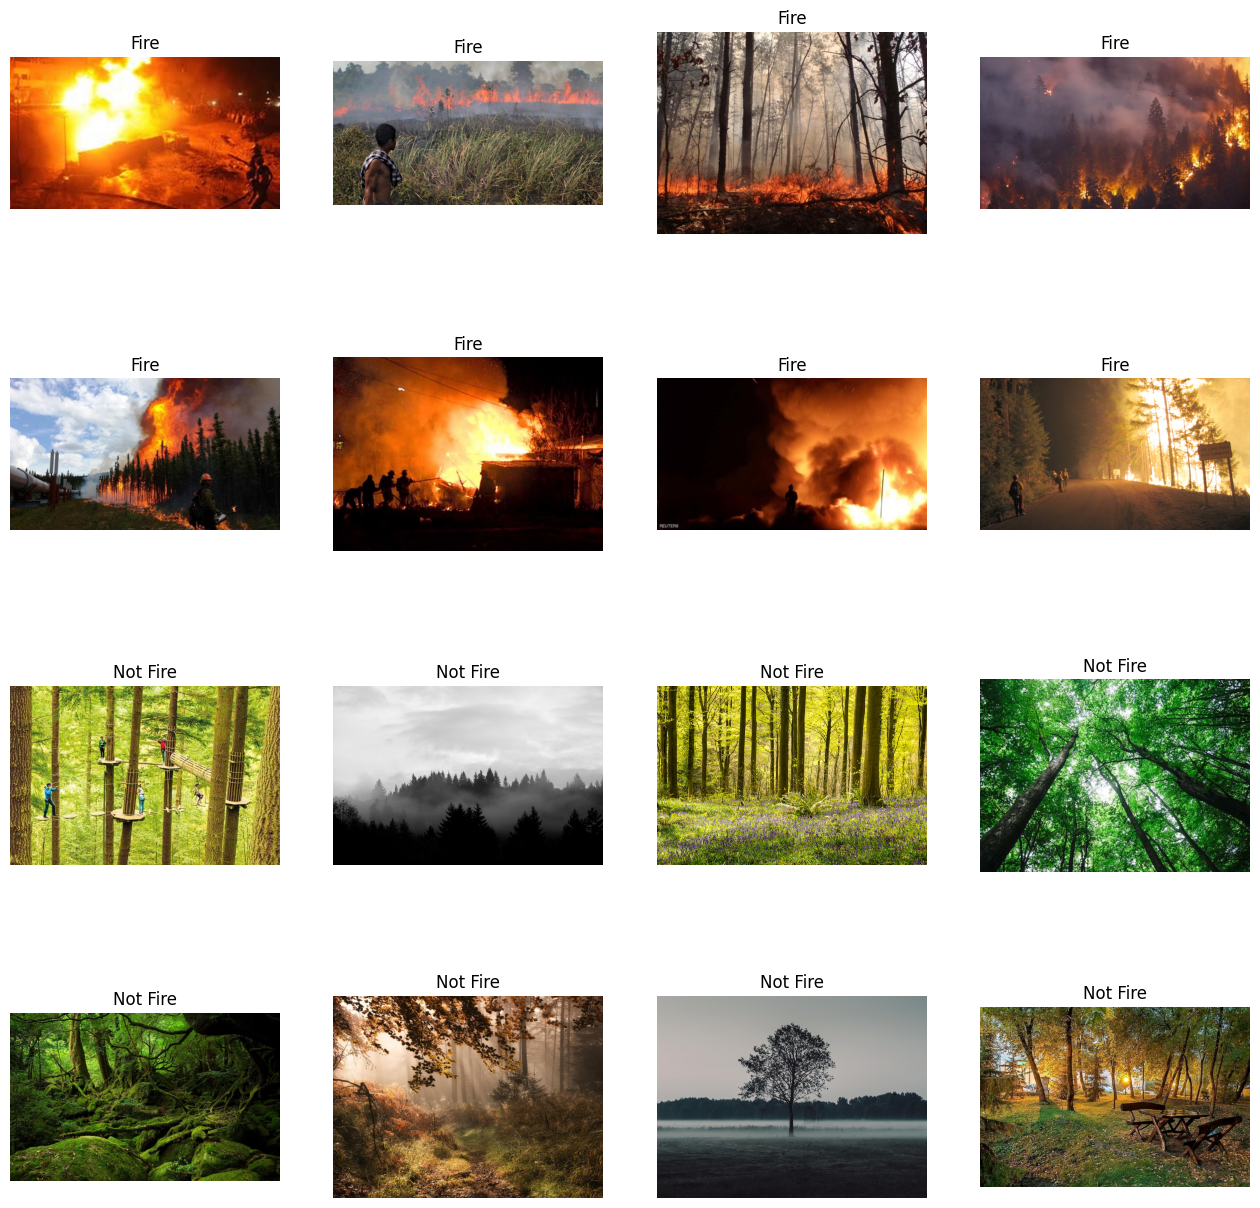

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import os

# Assuming you have lists train_fire and train_not_fire containing file names
fig_index = 0

# Setting number of columns and number of rows to view sample images
n_rows = 4
n_cols = 4

# Here we are using gcf to clear the plot if the cell is being run 2 or more times
fig = plt.gcf()

# Setting the size of each image
fig.set_size_inches(n_rows * 4, n_cols * 4)

# Incrementing the figure index by 8
fig_index += 8
# Pulling 8 images from each class to display
fire_8 = [os.path.join(train_data, 'fire_images', fname) for fname in train_fire[fig_index-8:fig_index]]
not_fire_8 = [os.path.join(train_data, 'non_fire_images', fname) for fname in train_not_fire[fig_index-8:fig_index]]

# Create labels for each image
labels = ['Fire'] * 8 + ['Not Fire'] * 8

# Printing the images from each class along with labels
for i, (img_path, label) in enumerate(zip(fire_8 + not_fire_8, labels)):
    sp = plt.subplot(n_rows, n_cols, i + 1)
    sp.axis('Off')

    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR format
        plt.imshow(img)
    except Exception as e:
        print(f"Error loading image at {img_path}: {e}")
        continue  # Skip to the next iteration if there's an error

    plt.title(label)

# Display the plot
plt.show()

#**🔥 Pre-processing the Images 🔥**






Data Augmentation

In [ ]:
# Data augmentation configuration

datagen = ImageDataGenerator(
    width_shift_range=0.5,    # Randomly shift images horizontally by up to 50%
    height_shift_range=0.5,   # Randomly shift images vertically by up to 50%
    validation_split=0.2      # Reserve 20% of the data for validation
)

# Create training generator with a subset for training data

train_generator = datagen.flow_from_directory(
    train_data,               # Path to the directory containing the training data
    target_size=(300, 300),   # Resize images to 300x300 pixels
    batch_size=8,             # Number of images in each batch
    class_mode='binary',      # Type of classification task (binary in this case)
    subset='training'         # Generate data for the training subset
)

# Create validation generator with a subset for validation data

validation_generator = datagen.flow_from_directory(
    train_data,               # Path to the directory containing the training data
    target_size=(300, 300),   # Resize images to 300x300 pixels
    batch_size=8,             # Number of images in each batch
    class_mode='binary',      # Type of classification task (binary in this case)
    subset='validation'       # Generate data for the validation subset
)
# <-------------------------------------------- Example of how the process works -------------------------------------------->

# 80% of 600 images from each class (480 images per class) are used for training. So, you have 480 (Fire) + 480 (Not Fire) = 960 training images.
# The remaining 20% of 600 images from each class (120 images per class) are used for validation. So, you have 120 (Fire) + 120 (Not Fire) = 240 validation images.

Found 808 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


# **Building Resnet-50 Model**

In [ ]:
# Load pre-trained ResNet50 with imagenet weights
pre_trained_resnet_50 = ResNet50(include_top=False, input_shape=(300, 300, 3), pooling='avg', weights='imagenet')

# Freeze layers up to the 39th layer
for layer in pre_trained_resnet_50.layers[:39]:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(pre_trained_resnet_50)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 24357377 (92.92 MB)
Non-trainable params: 279936 (1.07 MB)
_________________________________________________________________


Callbacks and optmizers

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Using tensorflow's Model-Checkpoint to save best model having less validation loss
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/final_model.h5',monitor='val_loss',save_best_only = True)

# Using Adam's optimizer to optimize our model to better learn on our dataset
model.compile(optimizer = tf.keras.optimizers.Adam() ,loss = 'binary_crossentropy',metrics = 'accuracy')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model on the fire dataset
history = model.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator,
      callbacks=[lr_scheduler, model_checkpoint, early_stopping]
  )

Epoch 1/100
101/101 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.3911

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 93s 539ms/step - loss: 0.8911 - accuracy: 0.3911 - val_loss: 0.8416 - val_accuracy: 0.3383 - lr: 1.0000e-08
Epoch 2/100
101/101 [==============================] - 52s 511ms/step - loss: 0.8950 - accuracy: 0.3824 - val_loss: 0.8285 - val_accuracy: 0.3831 - lr: 1.1220e-08
Epoch 3/100
101/101 [==============================] - 53s 528ms/step - loss: 0.8950 - accuracy: 0.3899 - val_loss: 0.8239 - val_accuracy: 0.3831 - lr: 1.2589e-08
Epoch 4/100
101/101 [==============================] - 52s 513ms/step - loss: 0.8818 - accuracy: 0.4121 - val_loss: 0.8119 - val_accuracy: 0.3284 - lr: 1.4125e-08
Epoch 5/100
101/101 [==============================] - 54s 535ms/step - loss: 0.8553 - accuracy: 0.4245 - val_loss: 0.8123 - val_accuracy: 0.3781 - lr: 1.5849e-08
Epoch 6/100
101/101 [==============================] - 52s 511ms/step - loss: 0.9015 - accuracy: 0.3948 - val_loss: 0.8019 - val_accuracy: 0.3781 - lr: 1.7783e-08
Epoch 7/100
101/101 [=============

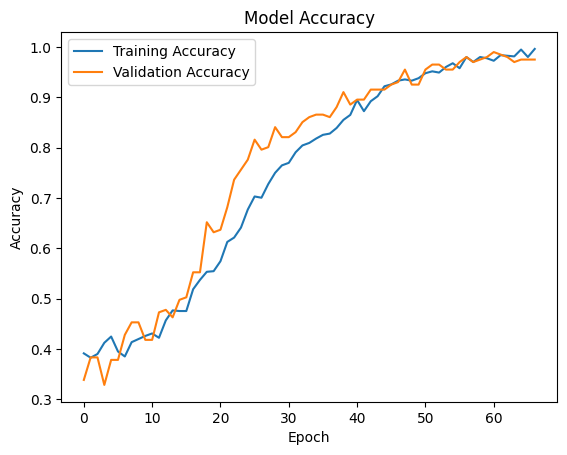

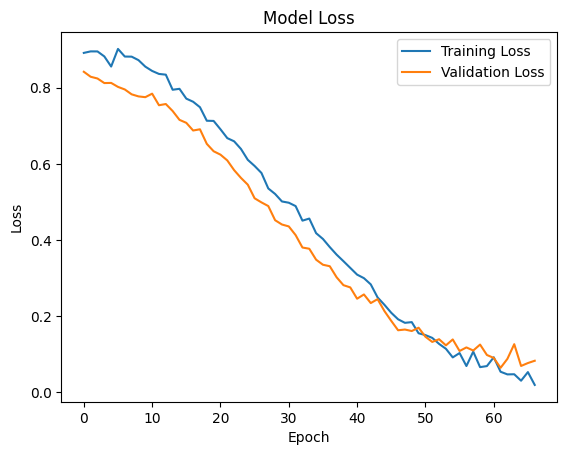

In [ ]:
def plot_training_history(history):
    # Plotting model accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plotting model loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_training_history(history)

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model('/content/final_model.h5')

# Evaluate the model on the provided data generator
evaluation_result = best_model.evaluate(validation_generator)

# Print the evaluation result
print("Final Evaluation Result:", evaluation_result)

26/26 [==============================] - 9s 320ms/step - loss: 0.1005 - accuracy: 0.9751
Final Evaluation Result: [0.10050975531339645, 0.9751243591308594]


# Test the model

In [ ]:
def predict_and_display(model, filename, class_names, img_shape=300):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model, preprocesses the image, and plots the image with the
    predicted class as the title.

    Parameters:
    - model: The trained model for image classification.
    - filename: The path to the image file.
    - class_names: A list of class names.
    - img_shape: The desired image shape for preprocessing (default is 300).
    """
    # Load and preprocess the image
    img = load_and_preprocess_image(filename, img_shape)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Determine the predicted class
    pred_class = get_predicted_class_name(pred, class_names)

    # Plot the image and predicted class
    display_image_with_prediction(img, pred_class)

def load_and_preprocess_image(filename, img_shape=300):
    """
    Load and preprocess an image from the given filename.

    Parameters:
    - filename: The path to the image file.
    - img_shape: 300x300 image shape for preprocessing.

    Returns:
    - img: The preprocessed image as a TensorFlow tensor.
    """
    img = tf.io.read_file(filename)  # read image
    img = tf.image.decode_image(img)  # decode the image to a tensor
    img = tf.image.resize(img, size=[img_shape, img_shape])  # resize the image
    return img

def get_predicted_class_name(pred, class_names):
    """
    Determine the predicted class based on the model's prediction.

    Parameters:
    - pred: The model's prediction.
    - class_names: A list of class names.

    Returns:
    - pred_class: The predicted class.
    """
    if len(pred[0]) > 1:
        pred_class = class_names[pred.argmax()]  # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])]  # if only one output, round
    return pred_class

def display_image_with_prediction(img, pred_class):
    """
    Plot the preprocessed image with the predicted class as the title.

    Parameters:
    - img: The preprocessed image as a TensorFlow tensor.
    - pred_class: The predicted class.
    """
    plt.imshow(img.numpy().astype("uint8"))  # Display the preprocessed image
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()

1/1 [==============================] - 2s 2s/step


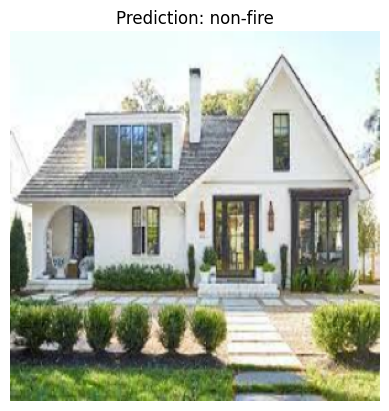

In [ ]:
# Load the image specifying the path to the sample image from the list of test images.
sample_img = '/content/Test/safehouse.png'
# Predefining class names to avoid confusion with the output
class_names = ['fire', 'non-fire']
# Reading the input and checking the output
predict_and_display(best_model, sample_img, class_names)

1/1 [==============================] - 0s 39ms/step


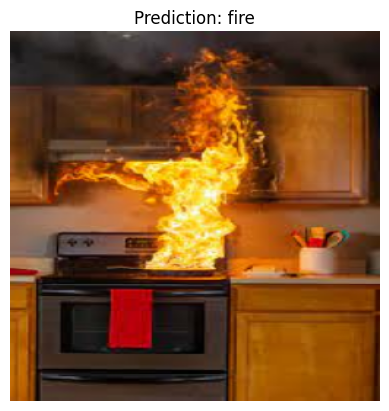

In [ ]:
# Load the image specifying the path to the sample image from the list of test images.
sample_img = '/content/Test/kitchen.jpeg'
class_names = ['fire', 'non-fire']
# Reading the input and checking the output
predict_and_display(best_model, sample_img, class_names)

1/1 [==============================] - 0s 22ms/step


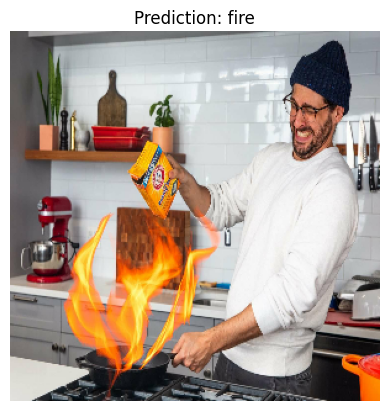

In [ ]:
# Load the image specifying the path to the sample image from the list of test images.
sample_img = '/content/Test/man.jpg'
class_names = ['fire', 'non-fire']
# Reading the input and checking the output
predict_and_display(best_model, sample_img, class_names)

1/1 [==============================] - 0s 44ms/step


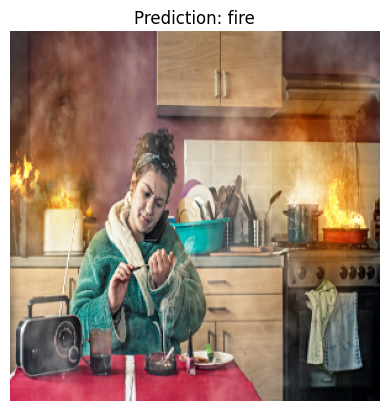

In [ ]:
# Load the image
# specifying path to sample image from list of test images.
sample_img = '/content/Test/cookingsafe.jpeg'
# predefining class names so not to confuse with the output
class_names = ['fire', 'non-fire']
# Reading the input and checking the output
predict_and_display(best_model, sample_img, class_names)

1/1 [==============================] - 0s 113ms/step


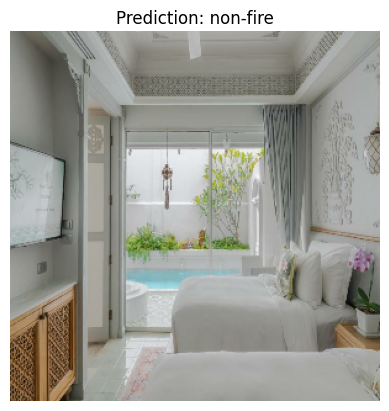

In [ ]:
# Load the image
# specifying path to sample image from list of test images.
sample_img = '/content/Test/4.jpeg'
# predefining class names so not to confuse with the output
class_names = ['fire', 'non-fire']
# Reading the input and checking the output
predict_and_display(best_model, sample_img, class_names)

1/1 [==============================] - 0s 66ms/step


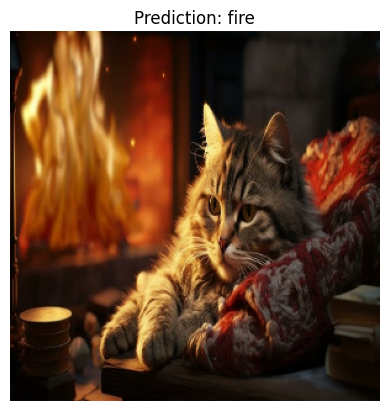

In [ ]:
# Load the image
# specifying path to sample image from list of test images.
sample_img = '/content/Test/cat.jpeg'
# predefining class names so not to confuse with the output
class_names = ['fire', 'non-fire']
# Reading the input and checking the output
predict_and_display(best_model, sample_img, class_names)